In [50]:
import pickle
import warnings
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
warnings.filterwarnings('ignore')
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import r2_score, root_mean_squared_error

## Data preparation and data cleaning

In [2]:
df = pd.read_csv("./Data/insurance.csv")

In [3]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [4]:
# Check for missing values
df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [5]:
# Categorical variable
categorical_vars = df.select_dtypes(exclude="number").columns
for var in categorical_vars:
    print(df[var].value_counts())

sex
male      676
female    662
Name: count, dtype: int64
smoker
no     1064
yes     274
Name: count, dtype: int64
region
southeast    364
southwest    325
northwest    325
northeast    324
Name: count, dtype: int64


In [6]:
# Encode categorical values
df_full = pd.get_dummies(df, drop_first=True, dtype=int)

In [7]:
df_full.describe()

,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
count,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265,0.505232,0.204783,0.242900,0.272048,0.242900
std,14.049960,6.098187,1.205493,12110.011237,0.500160,0.403694,0.428995,0.445181,0.428995
min,18.000000,15.960000,0.000000,1121.873900,0.000000,0.000000,0.000000,0.000000,0.000000
25%,27.000000,26.296250,0.000000,4740.287150,0.000000,0.000000,0.000000,0.000000,0.000000
50%,39.000000,30.400000,1.000000,9382.033000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,51.000000,34.693750,2.000000,16639.912515,1.000000,0.000000,0.000000,1.000000,0.000000
max,64.000000,53.130000,5.000000,63770.428010,1.000000,1.000000,1.000000,1.000000,1.000000


## Exploratory Data Analysis: feature importance analysis

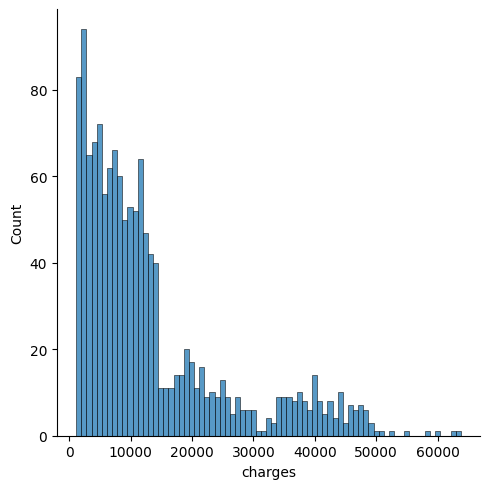

In [8]:
# Target variable distribution
sns.displot(df_full, x="charges", bins=75)

### Since the distribution of the target variable has a long tail end, we will use the log of it for modelling.

<Axes: xlabel='target', ylabel='Count'>

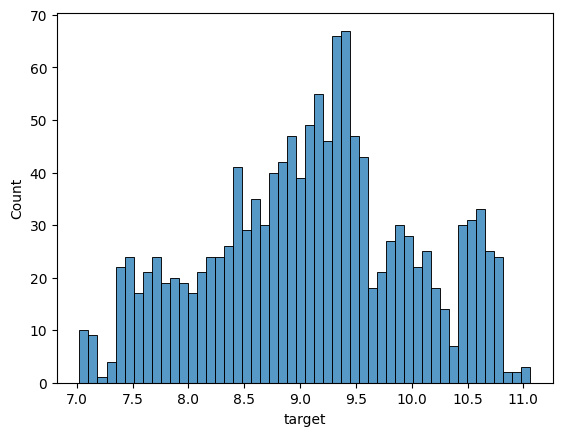

In [9]:
# New target distribution
df_full["target"] = np.log1p(df_full.charges)
sns.histplot(df_full.target, bins=50)

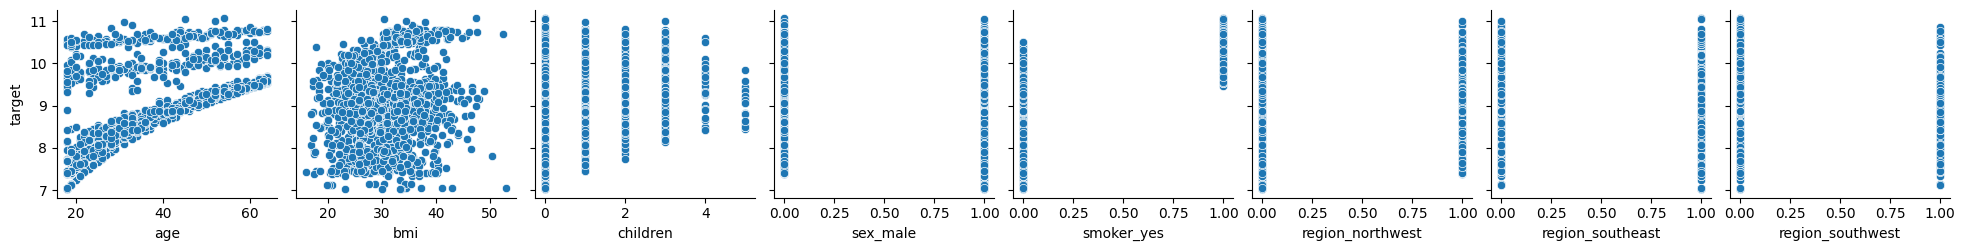

In [10]:
X = df_full.drop(columns=["charges", 'target'])
y = df_full["target"]

sns.pairplot(df_full, y_vars=['target'], x_vars=X.columns);

From the pair plot of the dependent variables and the target variable:
- The **age** variable appears to be correlated with the target. As the age increases, the medical cost increases
- The **children** variable also follows the same pattern; with more children, the medical costs increase
- Finally, **smokers** have a higher medical cost than non-smokers
- The other variables do not appear correlated just by looking at the plots

In [11]:
scores = mutual_info_regression(X, y).tolist()
variables = X.columns
pairs = zip(variables, scores)
for pair in sorted(pairs, key=lambda x: x[1], reverse=True):
    print(pair)

('age', 1.4992830593399091)
('smoker_yes', 0.3693933526662416)
('sex_male', 0.1762852857174464)
('children', 0.16101783950757786)
('bmi', 0.06719892514426462)
('region_northwest', 0.05833357471176992)
('region_southeast', 0.03621720948773666)
('region_southwest', 0.003390165442360926)


- The result of measuring the importance of features with mutual information tallies with conclusions from the plots.

- Surprisingly, the **sex** variable has higher importance than the **children** variable.

- Next, we look closer into the  **sex** variable.

In [12]:
females = y[X.sex_male == 0]
males = y[X.sex_male == 1]

print("Females: ", np.expm1(females.min()), np.expm1(females.max()))
print("Males: ",np.expm1(males.min()), np.expm1(males.max()))

Females:  1607.5100999999995 63770.428010000054
Males:  1121.8738999999998 62592.87308999997


- We see that the minimum medical cost for females is higher than that for males by **$486**
- The top important features are therefore: ***'age'***, ***'smoker'***, ***'sex'***, and ***'children'***
- Since there are few features (six), none will be excluded from the model selection process.

## Model selection process and parameter tuning

Models that will be considered are:
- Linear Regression
- Ridge Regression
- Lasso Regression
- Elastic Net
- Decision Tree Regression
- Random Forest Regression
- XGBoost
- K-Nearest Neighbors Regression

Because the dataset is not large, **cross-validation** is used for the model selection.

In [13]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
X_train.shape

(1070, 8)

In [15]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet

In [16]:
lr = LinearRegression()

lr_rmse = -1*np.average(cross_val_score(lr, X_train, y_train, cv=10, scoring='neg_root_mean_squared_error'))
lr_r2 = np.average(cross_val_score(lr, X_train, y_train, cv=10, scoring='r2'))

In [17]:
rr = Ridge(random_state=42)

rr_rmse = -1*np.average(cross_val_score(rr, X_train, y_train, cv=10, scoring='neg_root_mean_squared_error'))
rr_r2 = np.average(cross_val_score(rr, X_train, y_train, cv=10, scoring='r2'))

In [18]:
lsr = Lasso(random_state=42)

lsr_rmse = -1*np.average(cross_val_score(lsr, X_train, y_train, cv=10, scoring='neg_root_mean_squared_error'))
lsr_r2 = np.average(cross_val_score(lsr, X_train, y_train, cv=10, scoring='r2'))

In [19]:
enr = ElasticNet(random_state=42)

enr_rmse = -1*np.average(cross_val_score(enr, X_train, y_train, cv=10, scoring='neg_root_mean_squared_error'))
enr_r2 = np.average(cross_val_score(enr, X_train, y_train, cv=10, scoring='r2'))

In [20]:
from sklearn.tree import DecisionTreeRegressor

In [21]:
dt = DecisionTreeRegressor(random_state=42)

dt_rmse = -1*np.average(cross_val_score(dt, X_train, y_train, cv=10, scoring='neg_root_mean_squared_error'))
dt_r2 = np.average(cross_val_score(dt, X_train, y_train, cv=10, scoring='r2'))

In [22]:
from sklearn.ensemble import RandomForestRegressor

In [23]:
rf = RandomForestRegressor(random_state=42)

rf_rmse = -1*np.average(cross_val_score(rf, X_train, y_train, cv=10, scoring='neg_root_mean_squared_error'))
rf_r2 = np.average(cross_val_score(rf, X_train, y_train, cv=10, scoring='r2'))

In [24]:
from xgboost import XGBRegressor

In [25]:
xgb = XGBRegressor(random_state=42)

xgb_rmse = -1*np.average(cross_val_score(xgb, X_train, y_train, cv=10, scoring='neg_root_mean_squared_error'))
xgb_r2 = np.average(cross_val_score(xgb, X_train, y_train, cv=10, scoring='r2'))

In [26]:
from sklearn.neighbors import KNeighborsRegressor

In [27]:
knn = KNeighborsRegressor()

knn_rmse = -1*np.average(cross_val_score(knn, X_train, y_train, cv=10, scoring='neg_root_mean_squared_error'))
knn_r2 = np.average(cross_val_score(knn, X_train, y_train, cv=10, scoring='r2'))

In [28]:
columns = ["Model", "RMSE", "R2"]
models = ["Linear", "Ridge", "Lasso", "ElasticNet", "Decision Tree", "Random Forest", "XGBoost", "KNN"]
rmses = [lr_rmse, rr_rmse, lsr_rmse, enr_rmse, dt_rmse, rf_rmse, xgb_rmse, knn_rmse]
r2s = [lr_r2, rr_r2, lsr_r2, enr_r2, dt_r2, rf_r2, xgb_r2, knn_r2]
model_performance = pd.DataFrame(zip(models, rmses, r2s), columns=columns)

### Comparing model RMSE values

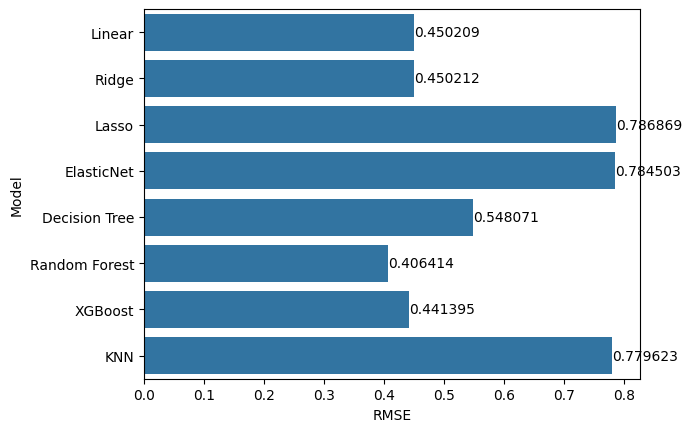

In [29]:
ax = sns.barplot(model_performance, x="RMSE", y="Model")
ax.bar_label(ax.containers[0]);

**Lower RMSE** values indicate better model performance because the prediction errors are smaller.

**Higher RMSE** values indicate that the model's predictions are farther from the actual values.

Based on the RMSE scores, the top-performing models are:
- **Random Forest**
- **Linear regression**
- **Ridge regression**
- **XGBoost**

### Comparing model R2 values

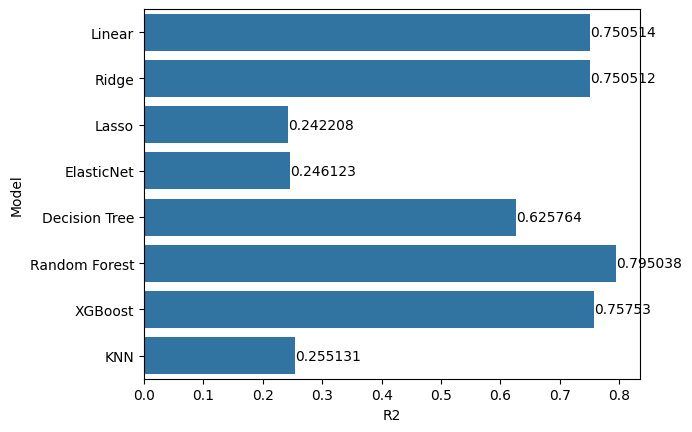

In [30]:
ax = sns.barplot(model_performance, x="R2", y="Model")
ax.bar_label(ax.containers[0]);

**Higher R²** values indicate that the model explains a greater proportion of the variance in the data, which suggests better predictive power.

**Lower R²** values suggest that the model is not capturing much of the variability in the target variable.

Based on the R² scores, the top-performing models:
- **Linear regression**
- **Ridge regression**
- **Random Forest**
- **XGBoost**

### Validation

In [31]:
rf.fit(X_train, y_train)

y_pred = rf.predict(X_val)

rf_rmse_val = root_mean_squared_error(y_val, y_pred)
rf_r2_val = r2_score(y_val, y_pred)

In [32]:
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

lr_rmse_val = root_mean_squared_error(y_val, y_pred)
lr_r2_val = r2_score(y_val, y_pred)

In [33]:
rr.fit(X_train, y_train)

y_pred = rr.predict(X_val)

rr_rmse_val = root_mean_squared_error(y_val, y_pred)
rr_r2_val = r2_score(y_val, y_pred)

In [34]:
xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_val)

dt_rmse_val = root_mean_squared_error(y_val, y_pred)
dt_r2_val = r2_score(y_val, y_pred)

In [35]:
columns = ["Model", "RMSE", "R2"]
models = ["Random Forest", "XGboost", "Linear", "Ridge"]
rmses = [rf_rmse_val, dt_rmse_val, lr_rmse_val, rr_rmse_val]
r2s = [rf_r2_val, dt_r2_val, lr_r2_val, rr_r2_val]
model_validation = pd.DataFrame(zip(models, rmses, r2s), columns=columns)

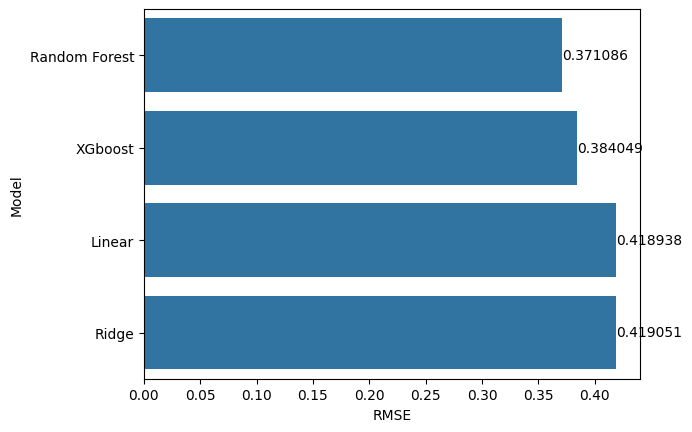

In [36]:
ax = sns.barplot(model_validation, x="RMSE", y="Model")
ax.bar_label(ax.containers[0]);

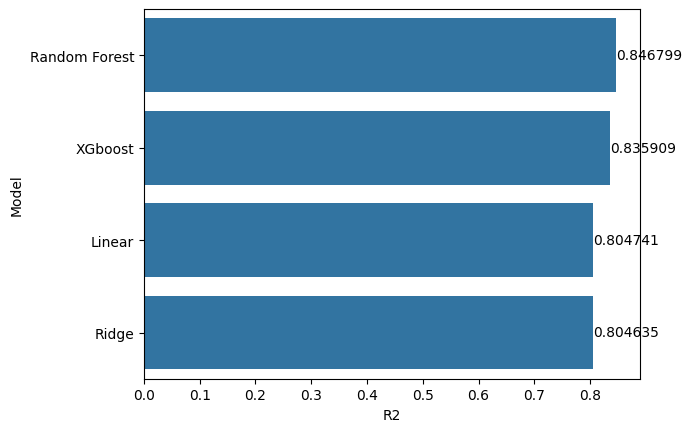

In [37]:
ax = sns.barplot(model_validation, x="R2", y="Model")
ax.bar_label(ax.containers[0]);

- Based on the validation resutls, **Random Forest classifier** gives the best result by both metrics -RMSE and R².

## Parameter Tuning

In [38]:
n_estimators= [100, 200, 300, 400, 500]
max_depth=  [None, 5, 10, 15, 20]

In [39]:
r2_scores = []
rmse_scores = []
for est in tqdm(n_estimators):
    for dep in max_depth:
        rf = RandomForestRegressor(n_estimators=est, max_depth=dep, random_state=42)
        r2_scores.append(cross_val_score(rf,X, y, cv=10, scoring='r2'))
        rmse_scores.append(cross_val_score(rf, X, y, cv=10, scoring='neg_root_mean_squared_error'))
        
r2_scores =[np.average(i) for i in r2_scores]
rmse_scores =[-1*np.average(i) for i in rmse_scores]       

100%|████████████████████████████████████████████| 5/5 [09:54<00:00, 118.81s/it]


In [40]:
columns = ["Estimators", "Depth", "RMSE", "R2"]
df_tuning = pd.DataFrame(zip(np.repeat(n_estimators, 5), np.tile(max_depth, 5), rmse_scores, r2_scores), columns=columns)

In [64]:
df_tuning.head()

,Estimators,Depth,RMSE,R2
0,100,NaN,0.393652,0.809095
1,100,5.0,0.367928,0.831340
2,100,10.0,0.387704,0.814566
3,100,15.0,0.393102,0.809613
4,100,20.0,0.393694,0.809066


In [42]:
df_tuning[df_tuning.RMSE == df_tuning.RMSE.min()]

,Estimators,Depth,RMSE,R2
16,400,5.0,0.367533,0.831743


In [43]:
df_tuning[df_tuning.R2 == df_tuning.R2.max()]

,Estimators,Depth,RMSE,R2
21,500,5.0,0.367555,0.831775


- The optimal **depth is 5**.
- For the number of estimators, we go with **400** since the R² is equal by up to 4 decimal places, but the RMSE is slightly improved. Also, this is less computationally demanding than 500 estimators.

## Train final model

In [60]:
def train(X_train, y_train, n_estimators=400, max_depth=5):
    
    X_full = pd.get_dummies(X_train, drop_first=True, dtype=int)
    
    rf = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
    rf.fit(X_train, y_train)

    return rf
    

In [61]:
def predict(X_test, model):
    X_full = pd.get_dummies(X_test, drop_first=True, dtype=int)
    y_pred = model.predict(X_test)

    return y_pred, np.expm1(y_pred)
    

In [62]:
# Test
model = train(X_train, y_train)
y_pred, true_pred = predict(X_val, model)

rmse = root_mean_squared_error(y_val, y_pred)
round(rmse, 4)

np.float64(0.3535)

## Does feature selection improve the performance?

#### Running the cells below might raise the following error errors:

```AttributeError: np.NINF was removed in the NumPy 2.0 release. Use -np.inf instead.```

#### If so, do the following on your terminal:
- ```cd ~/.local/share/virtualenvs/medical-cost-prediction-7uwt_u-q/lib/python3.11/site-packages/mlxtend/feature_selection```
- ```nano exhaustive_feature_selector.py```
- In the first line of the ```finalize_fit``` function, replace ```max_score = np.NINF``` with ```max_score = -np.inf```
- Close (```CTRL + X```) and Save(```Y + ENTER```) file 

In [63]:
rf = RandomForestRegressor(n_estimators=400, max_depth=5, random_state=42)
efs1 = EFS(rf, 
           min_features=4,
           max_features=8,
           scoring='neg_root_mean_squared_error',
           print_progress=True,
           cv=5)

efs1 = efs1.fit(X, y)

Features: 163/163

In [65]:
print('Best accuracy score: %.4f' % np.abs(efs1.best_score_))

Best accuracy score: 0.3726


- No apparent improvement from reducing the number of features, so we will use all.

In [382]:
output_file = "model_5_100.bin"

with open(output_file, "wb") as f_out:
    pickle.dump(model, f_out)

In [14]:
import pickle
import numpy as np

In [4]:
model_file = "model_5_100.bin"
with open(model_file, "rb") as f_in:
    model = pickle.load(f_in)

In [6]:
    19 	female 	27.900 	0 	yes southwest 	16884.92400
1 	18 	male 	33.770 	1 	no 	southeast 	1725.55230
2 	28 	male 	33.000 	3 	no 	southeast 	4449.46200
3 	33 	male 	22.705 	0 	no 	northwest 	21984.47061
4 	32 	male 	28.880 	0 	no 	northwest 	3866.85520

100

In [16]:
client = [[32, 0, 1, 0]]
np.expm1(model.predict(client))

/home/unjoku/.local/share/virtualenvs/medical-cost-prediction-7uwt_u-q/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


array([3581.74384546])